In [1]:
import torch, torchvision
print(torch.__version__, torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


2.9.1+cu128 0.24.1+cu128
CUDA available: True


In [2]:
import json
import numpy as np
import uuid


class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

categories = {0: 'Small car', 1: 'Bus', 2: 'Truck', 3: 'Building'}

json_file = '../PROJECT/xview_detection/xview_det_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img in json_data['images'].values():
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    for json_ann in [elem for elem in json_data['annotations'].values()
                     if elem['image_id'] == json_img['image_id']]:
        obj = GenericObject()
        obj.id = json_ann['image_id']
        obj.bb = (
            int(json_ann['bbox'][0]),
            int(json_ann['bbox'][1]),
            int(json_ann['bbox'][2]),
            int(json_ann['bbox'][3]),
        )
        obj.category = json_ann['category_id']
        counts[obj.category] += 1
        image.add_object(obj)
    anns.append(image)

print(counts)

from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(
    anns, test_size=0.1, random_state=1, shuffle=True
)


# Map category_id -> 0-based index
catid_to_idx = {cat_id: i for i, cat_id in categories.items()}
num_classes = len(catid_to_idx)

def build_torch_annotations(anns, catid_to_idx):
    torch_anns = []
    for img_ann in anns:
        boxes = []
        labels = []
        for obj in img_ann.objects:
            boxes.append(list(obj.bb))  # [x1, y1, x2, y2]
            cls_idx = catid_to_idx[obj.category]   # 0..num_classes-1
            labels.append(cls_idx + 1)             # 1..num_classes (0 = background)
        torch_anns.append({
            "file_name": img_ann.filename,
            "boxes": boxes,
            "labels": labels,
        })
    return torch_anns

train_annotations = build_torch_annotations(anns_train, catid_to_idx)
valid_annotations = build_torch_annotations(anns_valid, catid_to_idx)


{'Small car': 188300, 'Bus': 6269, 'Truck': 10600, 'Building': 275943}


In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class MyDetectionDataset(Dataset):
    def __init__(self, annotations, image_dir="", transforms=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        file_name = ann["file_name"]

        if os.path.isabs(file_name) or self.image_dir == "":
            img_path = file_name
        else:
            img_path = os.path.join(self.image_dir, file_name)

        img = Image.open(img_path).convert("RGB")

        boxes = torch.as_tensor(ann["boxes"], dtype=torch.float32)
        labels = torch.as_tensor(ann["labels"], dtype=torch.int64)

        # 🔧 Filter out degenerate (zero / negative width or height) boxes
        if boxes.numel() > 0:
            x1 = boxes[:, 0]
            y1 = boxes[:, 1]
            x2 = boxes[:, 2]
            y2 = boxes[:, 3]

            #discard boxes with zero height or width 
            keep = (x2 > x1) & (y2 > y1)
            boxes = boxes[keep]
            labels = labels[keep]

        # if everything got filtered, still return empty tensors (allowed)
        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


train_tfms = T.Compose([T.ToTensor()])
val_tfms = T.Compose([T.ToTensor()])

image_root = '../PROJECT/xview_detection' 

train_dataset = MyDetectionDataset(train_annotations, image_dir=image_root, transforms=train_tfms)
valid_dataset = MyDetectionDataset(valid_annotations, image_dir=image_root, transforms=val_tfms)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False,
                          num_workers=4, collate_fn=collate_fn)

def compute_discard_stats(annotations):
    total = len(annotations)
    discarded = 0
    total_boxes = 0
    discarded_boxes = 0

    for ann in annotations:
        valid = 0
        for (x1, y1, x2, y2) in ann["boxes"]:
            total_boxes += 1
            if x2 > x1 and y2 > y1:
                valid += 1
            else:
                discarded_boxes += 1

        if valid == 0:
            discarded += 1

    return {
        "total_images": total,
        "images_discarded": discarded,
        "images_discarded_pct": 100 * discarded / total,
        "total_boxes": total_boxes,
        "boxes_discarded": discarded_boxes,
        "boxes_discarded_pct": 100 * discarded_boxes / total_boxes if total_boxes > 0 else 0,
    }

train_stats = compute_discard_stats(train_annotations)
valid_stats = compute_discard_stats(valid_annotations)

train_stats, valid_stats

({'total_images': 6845,
  'images_discarded': 0,
  'images_discarded_pct': 0.0,
  'total_boxes': 433210,
  'boxes_discarded': 7,
  'boxes_discarded_pct': 0.0016158445095911913},
 {'total_images': 761,
  'images_discarded': 0,
  'images_discarded_pct': 0.0,
  'total_boxes': 47902,
  'boxes_discarded': 0,
  'boxes_discarded_pct': 0.0})

In [4]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Cambia el predictor final a tus clases
num_classes = len(catid_to_idx) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Define anchors nuevos

anchor_generator = AnchorGenerator(
    sizes=((4,), (8,), (16,), (32,), (64,)),   # 1 size por nivel
    aspect_ratios=((0.5, 1.0, 2.0, 3.0),) * 5  # 4 ratios por nivel
)

# 4) Reemplaza anchor_generator
model.rpn.anchor_generator = anchor_generator

num_anchors = anchor_generator.num_anchors_per_location()[0]  
model.rpn.head = RPNHead(model.backbone.out_channels, num_anchors)

model.roi_heads.detections_per_img = 2000
model.roi_heads.score_thresh = 0.01
model.roi_heads.nms_thresh = 0.6


"""
model.rpn.pre_nms_top_n_train = 12000
model.rpn.pre_nms_top_n_test  = 6000
model.rpn.post_nms_top_n_train = 6000
model.rpn.post_nms_top_n_test  = 3000
"""

model.to(device)



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
import torch
from tqdm.auto import tqdm  # para la barra de progreso
# Número de épocas de entrenamiento
num_epochs = 100# pon aquí las que quieras
# Parámetros entrenables del modelo
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(
    params ,
    lr=1e-4,          
    weight_decay=1e-4,
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,  # número de épocas hasta LR mínimo
)

In [6]:
best_loss = float("inf")
best_epoch = -1
num_epochs = 100

paciencia = 20 # paciencia early stopping

history = {
    "loss": [],
    "loss_classifier": [],
    "loss_box_reg": [],
    "loss_objectness": [],
    "loss_rpn_box_reg": [],
}

for epoch in range(num_epochs):
    model.train()
    
    epoch_loss = 0.0
    loss_classifier = 0.0
    loss_box_reg = 0.0
    loss_objectness = 0.0
    loss_rpn_box_reg = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loss_classifier += loss_dict["loss_classifier"].item()
        loss_box_reg += loss_dict["loss_box_reg"].item()
        loss_objectness += loss_dict["loss_objectness"].item()
        loss_rpn_box_reg += loss_dict["loss_rpn_box_reg"].item()

    lr_scheduler.step()

    # Promedios por epoch
    epoch_loss /= len(train_loader)
    history["loss"].append(epoch_loss)
    history["loss_classifier"].append(loss_classifier / len(train_loader))
    history["loss_box_reg"].append(loss_box_reg / len(train_loader))
    history["loss_objectness"].append(loss_objectness / len(train_loader))
    history["loss_rpn_box_reg"].append(loss_rpn_box_reg / len(train_loader))

    print(f"Epoch {epoch+1} — loss: {epoch_loss:.4f}")

    # GUARDAR EL MEJOR MODELO
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch + 1
        
        torch.save(model.state_dict(), "Faster-RCNN_best_model_weights2.pth")

        print(f"Nuevo mejor modelo guardado en epoch {epoch+1} (loss={best_loss:.4f})")
    elif epoch - best_epoch > paciencia:
        print(f"Early stopping: no mejora en {paciencia} épocas. Mejor epoch: {best_epoch} (loss={best_loss:.4f})")
        break




Epoch 1/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 1 — loss: 0.9022


Nuevo mejor modelo guardado en epoch 1 (loss=0.9022)


Epoch 2/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 2 — loss: 0.8343


Nuevo mejor modelo guardado en epoch 2 (loss=0.8343)


Epoch 3/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

can only test a child process

AssertionError

: 

can only test a child process

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

can only test a child process

Exception ignored in: 

: 

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 3 — loss: 0.7986


Nuevo mejor modelo guardado en epoch 3 (loss=0.7986)


Epoch 4/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 4 — loss: 0.7659


Nuevo mejor modelo guardado en epoch 4 (loss=0.7659)


Epoch 5/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

AssertionError

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

AssertionError

can only test a child process

: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

AssertionError

Traceback (most recent call last):


can only test a child process

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 5 — loss: 0.7401


Nuevo mejor modelo guardado en epoch 5 (loss=0.7401)


Epoch 6/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 6 — loss: 0.7161


Nuevo mejor modelo guardado en epoch 6 (loss=0.7161)


Epoch 7/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

self._shutdown_workers()

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

AssertionError

: 

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

: 

Traceback (most recent call last):


self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

can only test a child process

Epoch 7 — loss: 0.6905


Nuevo mejor modelo guardado en epoch 7 (loss=0.6905)


Epoch 8/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 8 — loss: 0.6658


Nuevo mejor modelo guardado en epoch 8 (loss=0.6658)


Epoch 9/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

AssertionError

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

AssertionError

: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Epoch 9 — loss: 0.6441


Nuevo mejor modelo guardado en epoch 9 (loss=0.6441)


Epoch 10/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 10 — loss: 0.6241


Nuevo mejor modelo guardado en epoch 10 (loss=0.6241)


Epoch 11/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

: 

: 

can only test a child process

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

AssertionError

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

: 

can only test a child process

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 11 — loss: 0.6028


Nuevo mejor modelo guardado en epoch 11 (loss=0.6028)


Epoch 12/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 12 — loss: 0.5865


Nuevo mejor modelo guardado en epoch 12 (loss=0.5865)


Epoch 13/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

: 

can only test a child process

can only test a child process

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

Traceback (most recent call last):


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

can only test a child process

Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

AssertionError

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Epoch 13 — loss: 0.5648


Nuevo mejor modelo guardado en epoch 13 (loss=0.5648)


Epoch 14/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

if w.is_alive():

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

self._shutdown_workers()

AssertionError

can only test a child process

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 14 — loss: 0.5465


Nuevo mejor modelo guardado en epoch 14 (loss=0.5465)


Epoch 15/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

AssertionError

can only test a child process

AssertionError

: 

: 

: 

can only test a child process

can only test a child process

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

Exception ignored in: 

self._shutdown_workers()

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

if w.is_alive():

Exception ignored in: 

Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

self._shutdown_workers()

: 

if w.is_alive():

AssertionError

can only test a child process

: 

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

Exception ignored in: 

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

AssertionError

AssertionError

: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

: 

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

can only test a child process

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 15 — loss: 0.5283


Nuevo mejor modelo guardado en epoch 15 (loss=0.5283)


Epoch 16/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

if w.is_alive():

can only test a child process

Exception ignored in: 

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 16 — loss: 0.5122


Nuevo mejor modelo guardado en epoch 16 (loss=0.5122)


Epoch 17/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

AssertionError

: 

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

: 

can only test a child process

AssertionError

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

Exception ignored in: 

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

Exception ignored in: 

Traceback (most recent call last):


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

AssertionError

self._shutdown_workers()

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

if w.is_alive():

AssertionError

if w.is_alive():

AssertionError

: 

: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

AssertionError

: 

: 

can only test a child process

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

Exception ignored in: 

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 17 — loss: 0.4974


Nuevo mejor modelo guardado en epoch 17 (loss=0.4974)


Epoch 18/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 18 — loss: 0.4819


Nuevo mejor modelo guardado en epoch 18 (loss=0.4819)


Epoch 19/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

Exception ignored in: 

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


AssertionError

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 19 — loss: 0.4672


Nuevo mejor modelo guardado en epoch 19 (loss=0.4672)


Epoch 20/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 20 — loss: 0.4539


Nuevo mejor modelo guardado en epoch 20 (loss=0.4539)


Epoch 21/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

: 

AssertionError

can only test a child process

self._shutdown_workers()

: 

can only test a child process

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

Exception ignored in: 

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

Traceback (most recent call last):


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

Epoch 21 — loss: 0.4372


Nuevo mejor modelo guardado en epoch 21 (loss=0.4372)


Epoch 22/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 22 — loss: 0.4259


Nuevo mejor modelo guardado en epoch 22 (loss=0.4259)


Epoch 23/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

if w.is_alive():

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

Traceback (most recent call last):


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 23 — loss: 0.4114


Nuevo mejor modelo guardado en epoch 23 (loss=0.4114)


Epoch 24/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 24 — loss: 0.4025


Nuevo mejor modelo guardado en epoch 24 (loss=0.4025)


Epoch 25/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

Exception ignored in: 

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

AssertionError

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

AssertionError

: 

Exception ignored in: 

: 

can only test a child process

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 25 — loss: 0.3906


Nuevo mejor modelo guardado en epoch 25 (loss=0.3906)


Epoch 26/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 26 — loss: 0.3796


Nuevo mejor modelo guardado en epoch 26 (loss=0.3796)


Epoch 27/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

Traceback (most recent call last):


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

AssertionError

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

can only test a child process

Exception ignored in: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 27 — loss: 0.3700


Nuevo mejor modelo guardado en epoch 27 (loss=0.3700)


Epoch 28/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 28 — loss: 0.3595


Nuevo mejor modelo guardado en epoch 28 (loss=0.3595)


Epoch 29/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

Exception ignored in: 

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


AssertionError

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

can only test a child process

self._shutdown_workers()

AssertionError

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

if w.is_alive():

Exception ignored in: 

if w.is_alive():

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 29 — loss: 0.3504


Nuevo mejor modelo guardado en epoch 29 (loss=0.3504)


Epoch 30/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 30 — loss: 0.3417


Nuevo mejor modelo guardado en epoch 30 (loss=0.3417)


Epoch 31/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

self._shutdown_workers()

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 31 — loss: 0.3322


Nuevo mejor modelo guardado en epoch 31 (loss=0.3322)


Epoch 32/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 32 — loss: 0.3242


Nuevo mejor modelo guardado en epoch 32 (loss=0.3242)


Epoch 33/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

: 

can only test a child process

AssertionError

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

AssertionError

: 

can only test a child process

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

AssertionError

: 

can only test a child process

Epoch 33 — loss: 0.3150


Nuevo mejor modelo guardado en epoch 33 (loss=0.3150)


Epoch 34/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 34 — loss: 0.3081


Nuevo mejor modelo guardado en epoch 34 (loss=0.3081)


Epoch 35/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

self._shutdown_workers()

can only test a child process

AssertionError

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

self._shutdown_workers()

AssertionError

can only test a child process

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 35 — loss: 0.3012


Nuevo mejor modelo guardado en epoch 35 (loss=0.3012)


Epoch 36/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 36 — loss: 0.2930


Nuevo mejor modelo guardado en epoch 36 (loss=0.2930)


Epoch 37/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

Exception ignored in: 

AssertionError

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

: 

can only test a child process

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

self._shutdown_workers()

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 37 — loss: 0.2844


Nuevo mejor modelo guardado en epoch 37 (loss=0.2844)


Epoch 38/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 38 — loss: 0.2776


Nuevo mejor modelo guardado en epoch 38 (loss=0.2776)


Epoch 39/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

: 

self._shutdown_workers()

can only test a child process

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

: 

if w.is_alive():

can only test a child process

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 39 — loss: 0.2700


Nuevo mejor modelo guardado en epoch 39 (loss=0.2700)


Epoch 40/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 40 — loss: 0.2623


Nuevo mejor modelo guardado en epoch 40 (loss=0.2623)


Epoch 41/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

AssertionError

: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 41 — loss: 0.2562


Nuevo mejor modelo guardado en epoch 41 (loss=0.2562)


Epoch 42/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 42 — loss: 0.2495


Nuevo mejor modelo guardado en epoch 42 (loss=0.2495)


Epoch 43/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

if w.is_alive():

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 43 — loss: 0.2440


Nuevo mejor modelo guardado en epoch 43 (loss=0.2440)


Epoch 44/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 44 — loss: 0.2364


Nuevo mejor modelo guardado en epoch 44 (loss=0.2364)


Epoch 45/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

self._shutdown_workers()

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

self._shutdown_workers()

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 45 — loss: 0.2307


Nuevo mejor modelo guardado en epoch 45 (loss=0.2307)


Epoch 46/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 46 — loss: 0.2245


Nuevo mejor modelo guardado en epoch 46 (loss=0.2245)


Epoch 47/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

Traceback (most recent call last):


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

Exception ignored in: 

self._shutdown_workers()

can only test a child process

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

AssertionError

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 47 — loss: 0.2183


Nuevo mejor modelo guardado en epoch 47 (loss=0.2183)


Epoch 48/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 48 — loss: 0.2130


Nuevo mejor modelo guardado en epoch 48 (loss=0.2130)


Epoch 49/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


: 

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

: 

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

Exception ignored in: 

: 

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

: 

: 

can only test a child process

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 49 — loss: 0.2073


Nuevo mejor modelo guardado en epoch 49 (loss=0.2073)


Epoch 50/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 50 — loss: 0.2017


Nuevo mejor modelo guardado en epoch 50 (loss=0.2017)


Epoch 51/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

AssertionError

: 

AssertionError

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

: 

: 

can only test a child process

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

if w.is_alive():

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

: 

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 51 — loss: 0.1948


Nuevo mejor modelo guardado en epoch 51 (loss=0.1948)


Epoch 52/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 52 — loss: 0.1900


Nuevo mejor modelo guardado en epoch 52 (loss=0.1900)


Epoch 53/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

AssertionError

: 

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

self._shutdown_workers()

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

if w.is_alive():

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 53 — loss: 0.1847


Nuevo mejor modelo guardado en epoch 53 (loss=0.1847)


Epoch 54/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 54 — loss: 0.1796


Nuevo mejor modelo guardado en epoch 54 (loss=0.1796)


Epoch 55/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

AssertionError

: 

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


can only test a child process

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

AssertionError

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

AssertionError

AssertionError

: 

: 

: 

can only test a child process

can only test a child process

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 55 — loss: 0.1744


Nuevo mejor modelo guardado en epoch 55 (loss=0.1744)


Epoch 56/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

AssertionError

: 

: 

can only test a child process

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

Traceback (most recent call last):


AssertionError

can only test a child process

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

AssertionError

: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

if w.is_alive():

if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

AssertionError

: 

: 

can only test a child process

Traceback (most recent call last):


Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

if w.is_alive():

if w.is_alive():

: 

can only test a child process

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

AssertionError

: 

can only test a child process

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 56 — loss: 0.1693


Nuevo mejor modelo guardado en epoch 56 (loss=0.1693)


Epoch 57/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 57 — loss: 0.1640


Nuevo mejor modelo guardado en epoch 57 (loss=0.1640)


Epoch 58/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

AssertionError

: 

: 

: 

can only test a child process

can only test a child process

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

Exception ignored in: 

if w.is_alive():

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

self._shutdown_workers()

can only test a child process

AssertionError

AssertionError

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 58 — loss: 0.1582


Nuevo mejor modelo guardado en epoch 58 (loss=0.1582)


Epoch 59/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 59 — loss: 0.1546


Nuevo mejor modelo guardado en epoch 59 (loss=0.1546)


Epoch 60/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

AssertionError

: 

AssertionError

: 

can only test a child process

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

AssertionError

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

can only test a child process

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 60 — loss: 0.1495


Nuevo mejor modelo guardado en epoch 60 (loss=0.1495)


Epoch 61/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Epoch 61 — loss: 0.1450


Nuevo mejor modelo guardado en epoch 61 (loss=0.1450)


Epoch 62/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

can only test a child process

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Epoch 62 — loss: 0.1401


Nuevo mejor modelo guardado en epoch 62 (loss=0.1401)


Epoch 63/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

AssertionError

can only test a child process

: 

AssertionError

can only test a child process

AssertionError

: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

Exception ignored in: 

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

Exception ignored in: 

AssertionError

: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

: 

can only test a child process

AssertionError

can only test a child process

: 

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


Traceback (most recent call last):


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

if w.is_alive():

AssertionError

if w.is_alive():

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

Exception ignored in: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

: 

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

AssertionError

: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

can only test a child process

Epoch 63 — loss: 0.1360


Nuevo mejor modelo guardado en epoch 63 (loss=0.1360)


Epoch 64/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

AssertionError

can only test a child process

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

can only test a child process

AssertionError

: 

Exception ignored in: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

self._shutdown_workers()

AssertionError

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

Traceback (most recent call last):


: 

AssertionError

Exception ignored in: 

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

can only test a child process

Exception ignored in: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 64 — loss: 0.1308


Nuevo mejor modelo guardado en epoch 64 (loss=0.1308)


Epoch 65/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

if w.is_alive():

can only test a child process

AssertionError

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

AssertionError

Traceback (most recent call last):


self._shutdown_workers()

Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

can only test a child process

: 

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

AssertionError

can only test a child process

: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Exception ignored in: 

Traceback (most recent call last):


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

AssertionError

Traceback (most recent call last):


self._shutdown_workers()

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Exception ignored in: 

if w.is_alive():

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

self._shutdown_workers()

can only test a child process

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

if w.is_alive():

can only test a child process

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


AssertionError

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

can only test a child process

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 65 — loss: 0.1266


Nuevo mejor modelo guardado en epoch 65 (loss=0.1266)


Epoch 66/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

if w.is_alive():

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

AssertionError

Exception ignored in: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

AssertionError

: 

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

Exception ignored in: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

self._shutdown_workers()

AssertionError

: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

if w.is_alive():

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

AssertionError

: 

can only test a child process

: 

self._shutdown_workers()

can only test a child process

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 66 — loss: 0.1224


Nuevo mejor modelo guardado en epoch 66 (loss=0.1224)


Epoch 67/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

AssertionError

: 

can only test a child process

AssertionError

: 

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

Exception ignored in: 

Traceback (most recent call last):


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

can only test a child process

AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

can only test a child process

if w.is_alive():

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

: 

can only test a child process

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

Exception ignored in: 

: 

: 

AssertionError

can only test a child process

can only test a child process

: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

can only test a child process

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

: 

Exception ignored in: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 67 — loss: 0.1195


Nuevo mejor modelo guardado en epoch 67 (loss=0.1195)


Epoch 68/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 68 — loss: 0.1152


Nuevo mejor modelo guardado en epoch 68 (loss=0.1152)


Epoch 69/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

self._shutdown_workers()

: 

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Exception ignored in: 

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

AssertionError

: 

Exception ignored in: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

: 

AssertionError

can only test a child process

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 69 — loss: 0.1116


Nuevo mejor modelo guardado en epoch 69 (loss=0.1116)


Epoch 70/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 70 — loss: 0.1072


Nuevo mejor modelo guardado en epoch 70 (loss=0.1072)


Epoch 71/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

: 

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

self._shutdown_workers()

: 

can only test a child process

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

: 

AssertionError

can only test a child process

can only test a child process

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 71 — loss: 0.1039


Nuevo mejor modelo guardado en epoch 71 (loss=0.1039)


Epoch 72/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 72 — loss: 0.1003


Nuevo mejor modelo guardado en epoch 72 (loss=0.1003)


Epoch 73/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


AssertionError

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

: 

can only test a child process

can only test a child process

AssertionError

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 73 — loss: 0.0968


Nuevo mejor modelo guardado en epoch 73 (loss=0.0968)


Epoch 74/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 74 — loss: 0.0937


Nuevo mejor modelo guardado en epoch 74 (loss=0.0937)


Epoch 75/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

AssertionError

Traceback (most recent call last):


: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

: 

can only test a child process

Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

can only test a child process

Epoch 75 — loss: 0.0908


Nuevo mejor modelo guardado en epoch 75 (loss=0.0908)


Epoch 76/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 76 — loss: 0.0877


Nuevo mejor modelo guardado en epoch 76 (loss=0.0877)


Epoch 77/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

self._shutdown_workers()

: 

can only test a child process

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

AssertionError

Traceback (most recent call last):


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

AssertionError

: 

self._shutdown_workers()

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 77 — loss: 0.0845


Nuevo mejor modelo guardado en epoch 77 (loss=0.0845)


Epoch 78/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


Traceback (most recent call last):


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

AssertionError

can only test a child process

Exception ignored in: 

: 

: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

Exception ignored in: 

AssertionError

AssertionError

: 

Traceback (most recent call last):


: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

if w.is_alive():

can only test a child process

self._shutdown_workers()

if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

: 

if w.is_alive():

can only test a child process

AssertionError

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

Exception ignored in: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

AssertionError

can only test a child process

: 

AssertionError

can only test a child process

if w.is_alive():

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 78 — loss: 0.0818


Nuevo mejor modelo guardado en epoch 78 (loss=0.0818)


Epoch 79/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 79 — loss: 0.0796


Nuevo mejor modelo guardado en epoch 79 (loss=0.0796)


Epoch 80/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

AssertionError

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

can only test a child process

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

AssertionError

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

if w.is_alive():

AssertionError

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 80 — loss: 0.0769


Nuevo mejor modelo guardado en epoch 80 (loss=0.0769)


Epoch 81/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 81 — loss: 0.0750


Nuevo mejor modelo guardado en epoch 81 (loss=0.0750)


Epoch 82/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

can only test a child process

AssertionError

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

Exception ignored in: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 82 — loss: 0.0728


Nuevo mejor modelo guardado en epoch 82 (loss=0.0728)


Epoch 83/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 83 — loss: 0.0706


Nuevo mejor modelo guardado en epoch 83 (loss=0.0706)


Epoch 84/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

if w.is_alive():

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

self._shutdown_workers()

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

: 

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 84 — loss: 0.0690


Nuevo mejor modelo guardado en epoch 84 (loss=0.0690)


Epoch 85/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 85 — loss: 0.0672


Nuevo mejor modelo guardado en epoch 85 (loss=0.0672)


Epoch 86/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

AssertionError

AssertionError

can only test a child process

: 

: 

: 

can only test a child process

can only test a child process

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

AssertionError

: 

AssertionError

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

: 

can only test a child process

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

AssertionError

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 86 — loss: 0.0654


Nuevo mejor modelo guardado en epoch 86 (loss=0.0654)


Epoch 87/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 87 — loss: 0.0638


Nuevo mejor modelo guardado en epoch 87 (loss=0.0638)


Epoch 88/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

AssertionError

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

AssertionError

: 

can only test a child process

AssertionError

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

AssertionError

can only test a child process

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Epoch 88 — loss: 0.0626


Nuevo mejor modelo guardado en epoch 88 (loss=0.0626)


Epoch 89/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

AssertionError

can only test a child process

: 

AssertionError

AssertionError

can only test a child process

: 

: 

can only test a child process

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

AssertionError

can only test a child process

: 

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

can only test a child process

AssertionError

: 

can only test a child process

Epoch 89 — loss: 0.0612


Nuevo mejor modelo guardado en epoch 89 (loss=0.0612)


Epoch 90/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

AssertionError

can only test a child process

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

can only test a child process

can only test a child process

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

Exception ignored in: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

can only test a child process

can only test a child process

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

Exception ignored in: 

: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

AssertionError

: 

: 

AssertionError

can only test a child process

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

self._shutdown_workers()

: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

: 

if w.is_alive():

can only test a child process

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 90 — loss: 0.0601


Nuevo mejor modelo guardado en epoch 90 (loss=0.0601)


Epoch 91/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

if w.is_alive():

: 

AssertionError

AssertionError

can only test a child process

: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

AssertionError

: 

AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

: 

can only test a child process

Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 91 — loss: 0.0593


Nuevo mejor modelo guardado en epoch 91 (loss=0.0593)


Epoch 92/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

if w.is_alive():

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

if w.is_alive():

if w.is_alive():

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

Exception ignored in: 

can only test a child process

AssertionError

: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

: 

can only test a child process

Traceback (most recent call last):


Exception ignored in: 

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

if w.is_alive():

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

AssertionError

Traceback (most recent call last):


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

Traceback (most recent call last):


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

can only test a child process

AssertionError

AssertionError

: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

self._shutdown_workers()

can only test a child process

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

: 

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

Exception ignored in: 

Exception ignored in: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

self._shutdown_workers()

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

if w.is_alive():

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

AssertionError

AssertionError

: 

: 

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 92 — loss: 0.0583


Nuevo mejor modelo guardado en epoch 92 (loss=0.0583)


Epoch 93/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 93 — loss: 0.0575


Nuevo mejor modelo guardado en epoch 93 (loss=0.0575)


Epoch 94/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

if w.is_alive():

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


AssertionError

can only test a child process

: 

: 

can only test a child process

if w.is_alive():

can only test a child process

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

AssertionError

Traceback (most recent call last):


: 

can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

Exception ignored in: 

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


: 

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

Traceback (most recent call last):


: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

: 

can only test a child process

Epoch 94 — loss: 0.0569


Nuevo mejor modelo guardado en epoch 94 (loss=0.0569)


Epoch 95/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 95 — loss: 0.0563


Nuevo mejor modelo guardado en epoch 95 (loss=0.0563)


Epoch 96/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

if w.is_alive():

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

AssertionError

can only test a child process

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

self._shutdown_workers()

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Exception ignored in: 

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

self._shutdown_workers()

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

AssertionError

: 

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

can only test a child process

Exception ignored in: 

AssertionError

: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

can only test a child process

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 96 — loss: 0.0560


Nuevo mejor modelo guardado en epoch 96 (loss=0.0560)


Epoch 97/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 97 — loss: 0.0559


Nuevo mejor modelo guardado en epoch 97 (loss=0.0559)


Epoch 98/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


self._shutdown_workers()

if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

Exception ignored in: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

AssertionError

: 

: 

can only test a child process

can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):


AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Traceback (most recent call last):


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


if w.is_alive():

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

self._shutdown_workers()

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


: 

AssertionError

can only test a child process

: 

can only test a child process

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

Exception ignored in: 

: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 98 — loss: 0.0554


Nuevo mejor modelo guardado en epoch 98 (loss=0.0554)


Epoch 99/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Epoch 99 — loss: 0.0553


Nuevo mejor modelo guardado en epoch 99 (loss=0.0553)


Epoch 100/100:   0%|          | 0/1712 [00:00<?, ?it/s]

Exception ignored in: 

Exception ignored in: 

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

self._shutdown_workers()

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

Exception ignored in: 

if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

assert self._parent_pid == os.getpid(), 'can only test a child process'

assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):


: 

AssertionError

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


can only test a child process

: 

assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process

AssertionError

: 

can only test a child process

self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

Exception ignored in: 

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


if w.is_alive():

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


AssertionError

assert self._parent_pid == os.getpid(), 'can only test a child process'

: 

AssertionError

can only test a child process

: 

can only test a child process

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: 

AssertionError

: 

can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x14a47ebaade0>

Traceback (most recent call last):


  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


self._shutdown_workers()

  File "/home/x467/x467528/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


if w.is_alive():

  File "/media/apps/avx512-2021/software/Anaconda3/2025.06-1/lib/python3.13/multiprocessing/process.py", line 160, in is_alive


assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

: 

can only test a child process

Epoch 100 — loss: 0.0551


Nuevo mejor modelo guardado en epoch 100 (loss=0.0551)


In [7]:
print("\nEntrenamiento finalizado.")
print(f"Mejor epoch: {best_epoch} con loss={best_loss:.4f}")

# Cargar el mejor modelo
model.load_state_dict(torch.load("Faster-RCNN_best_model_weights2.pth", map_location=device))
model.to(device)
model.eval()

print("Mejor modelo cargado correctamente.")



Entrenamiento finalizado.
Mejor epoch: 100 con loss=0.0551


Mejor modelo cargado correctamente.


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
%matplotlib inline

def area_intersection(boxes, box):
    xmin = np.maximum(np.min(boxes[:, 0::2], axis=1), np.min(box[0::2]))
    ymin = np.maximum(np.min(boxes[:, 1::2], axis=1), np.min(box[1::2]))
    xmax = np.minimum(np.max(boxes[:, 0::2], axis=1), np.max(box[0::2]))
    ymax = np.minimum(np.max(boxes[:, 1::2], axis=1), np.max(box[1::2]))
    w = np.maximum(xmax - xmin + 1.0, 0.0)
    h = np.maximum(ymax - ymin + 1.0, 0.0)
    return w * h

def area_union(boxes, box):
    area_anns = (np.max(box[0::2])-np.min(box[0::2])+1.0) * (np.max(box[1::2])-np.min(box[1::2])+1.0)
    area_pred = (np.max(boxes[:, 0::2], axis=1)-np.min(boxes[:, 0::2], axis=1)+1.0) * (np.max(boxes[:, 1::2], axis=1)-np.min(boxes[:, 1::2], axis=1)+1.0)
    return area_anns + area_pred - area_intersection(boxes, box)

def calc_iou(boxes, box):
    iou = area_intersection(boxes, box) / area_union(boxes, box)
    max_value = np.max(iou)
    max_index = np.argmax(iou)
    return max_value, max_index

def calc_ap(rec, prec):
    # First append sentinel values at the end
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))
    # Compute the precision envelope
    for i in range(mpre.size-1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    # To calculate area under PR curve, look for points where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]
    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i+1] - mrec[i]) * mpre[i+1])
    return ap

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

def draw_precision_recall(precisions, recalls, categories):
    # Draw precision-recall curves for each category
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    plt.axis([0, 1, 0, 1])
    c_dark = list(filter(lambda x: x.startswith('dark'), col.cnames.keys()))
    aps = []
    # Compare categories for a specific algorithm
    for idx in range(len(categories)):
        plt.plot(recalls[idx], precisions[idx], color=c_dark[idx], label=categories[idx], linewidth=4.0)
        aps.append(calc_ap(recalls[idx], precisions[idx]))
    handles, labels = ax.get_legend_handles_labels()
    labels = [str(val + ' [' + "{:.3f}".format(aps[idx]) + ']') for idx, val in enumerate(labels)]
    handles = [h for (ap, h) in sorted(zip(aps, handles), key=lambda x: x[0], reverse=True)]
    labels = [l for (ap, l) in sorted(zip(aps, labels), key=lambda x: x[0], reverse=True)]
    leg = plt.legend(handles, labels, loc='upper right')
    leg.set_zorder(100)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid("on", linestyle="--", linewidth=2.0)
    fig.tight_layout()
    plt.show()

In [9]:
import numpy as np
import torch
from tqdm import tqdm

iou_thresh = 0.5
eps = np.finfo(np.float64).eps

def box_iou_matrix(pred_boxes, gt_boxes):
    # pred_boxes: [P,4], gt_boxes: [G,4] in (x1,y1,x2,y2)
    P = len(pred_boxes); G = len(gt_boxes)
    if P == 0 or G == 0:
        return np.zeros((P, G), dtype=np.float64)

    inter = np.zeros((P, G), dtype=np.float64)
    uni   = np.zeros((P, G), dtype=np.float64)
    for p_idx, pb in enumerate(pred_boxes):
        inter[p_idx] = area_intersection(gt_boxes, pb)
        uni[p_idx]   = area_union(gt_boxes, pb)
    return inter / np.maximum(uni, eps)

def compute_map_vectors(model, dataset, device, num_classes):
    classes = list(range(1, num_classes + 1))
    confidences = {c: [] for c in classes}
    tps         = {c: [] for c in classes}
    npos        = {c: 0  for c in classes}  # nº de GTs por clase (en todo el dataset)

    model.eval()
    with torch.no_grad():
        for img, target in tqdm(dataset, desc="Evaluating mAP"):
            img_gpu = img.to(device)
            out = model([img_gpu])[0]

            pred_boxes  = out["boxes"].detach().cpu().numpy()
            pred_scores = out["scores"].detach().cpu().numpy()
            pred_labels = out["labels"].detach().cpu().numpy()

            gt_boxes  = target["boxes"].detach().cpu().numpy()
            gt_labels = target["labels"].detach().cpu().numpy()

            # contar GTs por clase (aunque la imagen tenga 0 GTs de algunas clases)
            for c in classes:
                npos[c] += int(np.sum(gt_labels == c))

            ious = box_iou_matrix(pred_boxes, gt_boxes)  # [P,G]

            # para matching 1-1 por clase, necesitamos saber qué GTs ya se usaron
            used_gt = np.zeros(len(gt_boxes), dtype=bool)

            # ordenar predicciones por score (global)
            order = np.argsort(-pred_scores)

            for p_idx in order:
                pl = int(pred_labels[p_idx])
                ps = float(pred_scores[p_idx])

                if pl < 1 or pl > num_classes:
                    continue

                confidences[pl].append(ps)

                # si no hay GTs, esta predicción es FP
                if len(gt_boxes) == 0:
                    tps[pl].append(0)
                    continue

                # solo GTs de la misma clase pl
                gt_same = np.where(gt_labels == pl)[0]
                if gt_same.size == 0:
                    tps[pl].append(0)
                    continue

                # entre esos GTs, elegir el de IoU máximo
                ious_p_same = ious[p_idx, gt_same]
                best_local = int(np.argmax(ious_p_same))
                best_gt = int(gt_same[best_local])
                best_iou = float(ious[p_idx, best_gt])

                if best_iou >= iou_thresh and not used_gt[best_gt]:
                    used_gt[best_gt] = True
                    tps[pl].append(1)
                else:
                    tps[pl].append(0)

    return confidences, tps, npos

def ap_from_pr(recall, precision):
    # Si tu calc_ap ya hace interpolación VOC/11pt/area, usa el tuyo.
    # Aquí un AP por integración con envolvente (VOC2010+ style):
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    return np.sum((mrec[idx+1] - mrec[idx]) * mpre[idx+1])

# ---- uso ----
NUM_CLASSES = 4
confidences, tps, npos = compute_map_vectors(model, valid_dataset, device, NUM_CLASSES)
id2name = {i+1: name for i, name in categories.items()}  # {1:'Small car',...}

ap_list = []
for cls_id, cls_name in id2name.items():
    scores = np.array(confidences[cls_id], dtype=np.float64)
    tp_arr = np.array(tps[cls_id], dtype=np.float64)

    if scores.size == 0:
        print(f"> {cls_name}: no predictions (AP=0)")
        ap_list.append(0.0)
        continue

    order = np.argsort(-scores)
    tp_sorted = tp_arr[order]
    fp_sorted = 1.0 - tp_sorted

    tp_cum = np.cumsum(tp_sorted)
    fp_cum = np.cumsum(fp_sorted)

    denom = max(npos[cls_id], 1)  # si no hay GTs de esa clase, AP se suele definir 0
    recall = tp_cum / denom
    precision = tp_cum / np.maximum(tp_cum + fp_cum, eps)

    ap = ap_from_pr(recall, precision)  # o calc_ap(recall, precision)
    ap_list.append(ap)

    print(f"> {cls_name}: npos={npos[cls_id]}  AP={ap*100:.3f}%  "
          f"R(end)={recall[-1]*100:.3f}%  P(end)={precision[-1]*100:.3f}%")

mean_ap = float(np.mean(ap_list))
print(f"mAP@{iou_thresh:.2f}: {mean_ap*100:.3f}%")


Evaluating mAP:   0%|          | 0/761 [00:00<?, ?it/s]

Evaluating mAP:   0%|          | 2/761 [00:00<00:50, 14.92it/s]

Evaluating mAP:   1%|          | 5/761 [00:00<00:38, 19.78it/s]

Evaluating mAP:   1%|          | 8/761 [00:00<00:35, 21.08it/s]

Evaluating mAP:   1%|▏         | 11/761 [00:00<00:31, 23.58it/s]

Evaluating mAP:   2%|▏         | 15/761 [00:00<00:29, 25.53it/s]

Evaluating mAP:   2%|▏         | 18/761 [00:00<00:27, 26.77it/s]

Evaluating mAP:   3%|▎         | 21/761 [00:00<00:27, 26.82it/s]

Evaluating mAP:   3%|▎         | 24/761 [00:00<00:29, 25.16it/s]

Evaluating mAP:   4%|▎         | 27/761 [00:01<00:28, 25.67it/s]

Evaluating mAP:   4%|▍         | 30/761 [00:01<00:27, 26.15it/s]

Evaluating mAP:   4%|▍         | 34/761 [00:01<00:25, 28.23it/s]

Evaluating mAP:   5%|▍         | 37/761 [00:01<00:27, 26.63it/s]

Evaluating mAP:   5%|▌         | 40/761 [00:01<00:27, 26.61it/s]

Evaluating mAP:   6%|▌         | 43/761 [00:01<00:26, 27.47it/s]

Evaluating mAP:   6%|▌         | 47/761 [00:01<00:26, 27.34it/s]

Evaluating mAP:   7%|▋         | 50/761 [00:01<00:25, 27.97it/s]

Evaluating mAP:   7%|▋         | 54/761 [00:02<00:25, 27.67it/s]

Evaluating mAP:   8%|▊         | 58/761 [00:02<00:24, 28.71it/s]

Evaluating mAP:   8%|▊         | 62/761 [00:02<00:23, 29.53it/s]

Evaluating mAP:   9%|▊         | 66/761 [00:02<00:23, 29.94it/s]

Evaluating mAP:   9%|▉         | 69/761 [00:02<00:26, 26.43it/s]

Evaluating mAP:   9%|▉         | 72/761 [00:02<00:27, 24.83it/s]

Evaluating mAP:  10%|▉         | 75/761 [00:02<00:26, 25.67it/s]

Evaluating mAP:  10%|█         | 78/761 [00:02<00:26, 26.12it/s]

Evaluating mAP:  11%|█         | 81/761 [00:03<00:26, 25.45it/s]

Evaluating mAP:  11%|█         | 84/761 [00:03<00:26, 25.79it/s]

Evaluating mAP:  11%|█▏        | 87/761 [00:03<00:25, 25.98it/s]

Evaluating mAP:  12%|█▏        | 91/761 [00:03<00:25, 26.52it/s]

Evaluating mAP:  12%|█▏        | 94/761 [00:03<00:27, 24.62it/s]

Evaluating mAP:  13%|█▎        | 97/761 [00:03<00:36, 18.05it/s]

Evaluating mAP:  13%|█▎        | 101/761 [00:04<00:30, 21.49it/s]

Evaluating mAP:  14%|█▎        | 104/761 [00:04<00:29, 22.38it/s]

Evaluating mAP:  14%|█▍        | 107/761 [00:04<00:29, 22.47it/s]

Evaluating mAP:  14%|█▍        | 110/761 [00:04<00:28, 23.11it/s]

Evaluating mAP:  15%|█▍        | 114/761 [00:04<00:25, 25.47it/s]

Evaluating mAP:  15%|█▌        | 117/761 [00:04<00:24, 26.31it/s]

Evaluating mAP:  16%|█▌        | 120/761 [00:04<00:25, 25.37it/s]

Evaluating mAP:  16%|█▌        | 123/761 [00:04<00:24, 25.67it/s]

Evaluating mAP:  17%|█▋        | 126/761 [00:04<00:26, 24.05it/s]

Evaluating mAP:  17%|█▋        | 129/761 [00:05<00:25, 25.09it/s]

Evaluating mAP:  17%|█▋        | 132/761 [00:05<00:23, 26.26it/s]

Evaluating mAP:  18%|█▊        | 135/761 [00:05<00:28, 21.75it/s]

Evaluating mAP:  18%|█▊        | 139/761 [00:05<00:25, 24.49it/s]

Evaluating mAP:  19%|█▊        | 142/761 [00:05<00:24, 24.85it/s]

Evaluating mAP:  19%|█▉        | 145/761 [00:05<00:26, 23.34it/s]

Evaluating mAP:  19%|█▉        | 148/761 [00:05<00:28, 21.32it/s]

Evaluating mAP:  20%|█▉        | 151/761 [00:06<00:28, 21.11it/s]

Evaluating mAP:  20%|██        | 155/761 [00:06<00:25, 24.04it/s]

Evaluating mAP:  21%|██        | 159/761 [00:06<00:23, 25.91it/s]

Evaluating mAP:  21%|██▏       | 162/761 [00:06<00:24, 24.89it/s]

Evaluating mAP:  22%|██▏       | 165/761 [00:06<00:26, 22.86it/s]

Evaluating mAP:  22%|██▏       | 168/761 [00:06<00:27, 21.75it/s]

Evaluating mAP:  22%|██▏       | 171/761 [00:06<00:26, 22.39it/s]

Evaluating mAP:  23%|██▎       | 174/761 [00:07<00:24, 24.01it/s]

Evaluating mAP:  23%|██▎       | 177/761 [00:07<00:23, 25.31it/s]

Evaluating mAP:  24%|██▍       | 181/761 [00:07<00:21, 26.63it/s]

Evaluating mAP:  24%|██▍       | 184/761 [00:07<00:21, 26.65it/s]

Evaluating mAP:  25%|██▍       | 188/761 [00:07<00:20, 28.06it/s]

Evaluating mAP:  25%|██▌       | 191/761 [00:07<00:28, 20.08it/s]

Evaluating mAP:  25%|██▌       | 194/761 [00:07<00:25, 21.95it/s]

Evaluating mAP:  26%|██▌       | 197/761 [00:08<00:24, 22.57it/s]

Evaluating mAP:  26%|██▋       | 201/761 [00:08<00:22, 24.82it/s]

Evaluating mAP:  27%|██▋       | 204/761 [00:08<00:21, 25.84it/s]

Evaluating mAP:  27%|██▋       | 207/761 [00:08<00:21, 26.09it/s]

Evaluating mAP:  28%|██▊       | 210/761 [00:08<00:20, 26.26it/s]

Evaluating mAP:  28%|██▊       | 213/761 [00:08<00:23, 23.64it/s]

Evaluating mAP:  29%|██▊       | 217/761 [00:08<00:21, 24.80it/s]

Evaluating mAP:  29%|██▉       | 220/761 [00:08<00:21, 24.78it/s]

Evaluating mAP:  29%|██▉       | 223/761 [00:09<00:21, 24.90it/s]

Evaluating mAP:  30%|██▉       | 226/761 [00:09<00:21, 25.08it/s]

Evaluating mAP:  30%|███       | 229/761 [00:09<00:20, 26.22it/s]

Evaluating mAP:  30%|███       | 232/761 [00:09<00:22, 23.37it/s]

Evaluating mAP:  31%|███       | 235/761 [00:09<00:21, 24.08it/s]

Evaluating mAP:  31%|███▏      | 238/761 [00:09<00:23, 22.20it/s]

Evaluating mAP:  32%|███▏      | 241/761 [00:09<00:22, 23.49it/s]

Evaluating mAP:  32%|███▏      | 245/761 [00:09<00:19, 25.81it/s]

Evaluating mAP:  33%|███▎      | 248/761 [00:10<00:19, 26.78it/s]

Evaluating mAP:  33%|███▎      | 252/761 [00:10<00:20, 25.42it/s]

Evaluating mAP:  34%|███▎      | 256/761 [00:10<00:18, 27.48it/s]

Evaluating mAP:  34%|███▍      | 259/761 [00:10<00:17, 27.95it/s]

Evaluating mAP:  34%|███▍      | 262/761 [00:10<00:17, 27.92it/s]

Evaluating mAP:  35%|███▍      | 265/761 [00:10<00:17, 28.00it/s]

Evaluating mAP:  35%|███▌      | 268/761 [00:10<00:19, 25.93it/s]

Evaluating mAP:  36%|███▌      | 272/761 [00:10<00:18, 27.06it/s]

Evaluating mAP:  36%|███▋      | 276/761 [00:11<00:16, 29.09it/s]

Evaluating mAP:  37%|███▋      | 280/761 [00:11<00:16, 28.37it/s]

Evaluating mAP:  37%|███▋      | 283/761 [00:11<00:16, 28.68it/s]

Evaluating mAP:  38%|███▊      | 287/761 [00:11<00:16, 29.27it/s]

Evaluating mAP:  38%|███▊      | 290/761 [00:11<00:16, 28.03it/s]

Evaluating mAP:  39%|███▊      | 294/761 [00:11<00:15, 29.35it/s]

Evaluating mAP:  39%|███▉      | 298/761 [00:11<00:15, 29.92it/s]

Evaluating mAP:  40%|███▉      | 301/761 [00:11<00:16, 28.02it/s]

Evaluating mAP:  40%|███▉      | 304/761 [00:12<00:16, 27.44it/s]

Evaluating mAP:  40%|████      | 307/761 [00:12<00:16, 27.93it/s]

Evaluating mAP:  41%|████      | 311/761 [00:12<00:15, 28.76it/s]

Evaluating mAP:  41%|████▏     | 314/761 [00:12<00:16, 27.93it/s]

Evaluating mAP:  42%|████▏     | 317/761 [00:12<00:15, 28.33it/s]

Evaluating mAP:  42%|████▏     | 320/761 [00:12<00:16, 27.19it/s]

Evaluating mAP:  43%|████▎     | 324/761 [00:12<00:15, 28.66it/s]

Evaluating mAP:  43%|████▎     | 327/761 [00:12<00:15, 27.91it/s]

Evaluating mAP:  43%|████▎     | 330/761 [00:12<00:16, 25.42it/s]

Evaluating mAP:  44%|████▍     | 334/761 [00:13<00:18, 22.95it/s]

Evaluating mAP:  44%|████▍     | 337/761 [00:13<00:18, 23.12it/s]

Evaluating mAP:  45%|████▍     | 340/761 [00:13<00:18, 22.65it/s]

Evaluating mAP:  45%|████▌     | 343/761 [00:13<00:18, 22.22it/s]

Evaluating mAP:  45%|████▌     | 346/761 [00:13<00:24, 17.06it/s]

Evaluating mAP:  46%|████▌     | 349/761 [00:13<00:21, 19.16it/s]

Evaluating mAP:  46%|████▋     | 352/761 [00:14<00:20, 19.69it/s]

Evaluating mAP:  47%|████▋     | 356/761 [00:14<00:17, 22.78it/s]

Evaluating mAP:  47%|████▋     | 359/761 [00:14<00:16, 24.27it/s]

Evaluating mAP:  48%|████▊     | 362/761 [00:14<00:15, 25.50it/s]

Evaluating mAP:  48%|████▊     | 366/761 [00:14<00:15, 25.96it/s]

Evaluating mAP:  49%|████▊     | 370/761 [00:14<00:15, 25.15it/s]

Evaluating mAP:  49%|████▉     | 373/761 [00:14<00:15, 25.71it/s]

Evaluating mAP:  49%|████▉     | 376/761 [00:14<00:14, 26.13it/s]

Evaluating mAP:  50%|████▉     | 379/761 [00:15<00:18, 20.13it/s]

Evaluating mAP:  50%|█████     | 382/761 [00:15<00:19, 19.87it/s]

Evaluating mAP:  51%|█████     | 385/761 [00:15<00:18, 20.19it/s]

Evaluating mAP:  51%|█████     | 389/761 [00:15<00:17, 21.53it/s]

Evaluating mAP:  52%|█████▏    | 393/761 [00:15<00:15, 24.17it/s]

Evaluating mAP:  52%|█████▏    | 397/761 [00:15<00:13, 26.72it/s]

Evaluating mAP:  53%|█████▎    | 400/761 [00:16<00:14, 24.78it/s]

Evaluating mAP:  53%|█████▎    | 403/761 [00:16<00:14, 24.71it/s]

Evaluating mAP:  53%|█████▎    | 407/761 [00:16<00:13, 26.71it/s]

Evaluating mAP:  54%|█████▍    | 410/761 [00:16<00:14, 24.40it/s]

Evaluating mAP:  54%|█████▍    | 414/761 [00:16<00:13, 26.46it/s]

Evaluating mAP:  55%|█████▍    | 418/761 [00:16<00:12, 27.42it/s]

Evaluating mAP:  55%|█████▌    | 422/761 [00:16<00:11, 28.46it/s]

Evaluating mAP:  56%|█████▌    | 425/761 [00:17<00:13, 25.65it/s]

Evaluating mAP:  56%|█████▋    | 429/761 [00:17<00:12, 26.64it/s]

Evaluating mAP:  57%|█████▋    | 432/761 [00:17<00:13, 23.98it/s]

Evaluating mAP:  57%|█████▋    | 435/761 [00:17<00:13, 23.82it/s]

Evaluating mAP:  58%|█████▊    | 438/761 [00:17<00:13, 24.77it/s]

Evaluating mAP:  58%|█████▊    | 441/761 [00:17<00:12, 24.90it/s]

Evaluating mAP:  58%|█████▊    | 445/761 [00:17<00:11, 27.35it/s]

Evaluating mAP:  59%|█████▉    | 448/761 [00:17<00:11, 27.98it/s]

Evaluating mAP:  59%|█████▉    | 451/761 [00:17<00:11, 27.01it/s]

Evaluating mAP:  60%|█████▉    | 454/761 [00:18<00:11, 27.31it/s]

Evaluating mAP:  60%|██████    | 458/761 [00:18<00:10, 28.99it/s]

Evaluating mAP:  61%|██████    | 462/761 [00:18<00:10, 29.57it/s]

Evaluating mAP:  61%|██████    | 465/761 [00:18<00:10, 28.47it/s]

Evaluating mAP:  62%|██████▏   | 469/761 [00:18<00:12, 22.85it/s]

Evaluating mAP:  62%|██████▏   | 472/761 [00:18<00:12, 23.22it/s]

Evaluating mAP:  62%|██████▏   | 475/761 [00:19<00:13, 21.51it/s]

Evaluating mAP:  63%|██████▎   | 478/761 [00:19<00:13, 20.95it/s]

Evaluating mAP:  63%|██████▎   | 481/761 [00:19<00:12, 22.75it/s]

Evaluating mAP:  64%|██████▎   | 484/761 [00:19<00:12, 21.75it/s]

Evaluating mAP:  64%|██████▍   | 487/761 [00:19<00:12, 22.52it/s]

Evaluating mAP:  65%|██████▍   | 491/761 [00:19<00:10, 25.02it/s]

Evaluating mAP:  65%|██████▍   | 494/761 [00:19<00:10, 24.62it/s]

Evaluating mAP:  65%|██████▌   | 497/761 [00:19<00:10, 24.66it/s]

Evaluating mAP:  66%|██████▌   | 500/761 [00:20<00:10, 24.19it/s]

Evaluating mAP:  66%|██████▌   | 503/761 [00:20<00:11, 22.21it/s]

Evaluating mAP:  66%|██████▋   | 506/761 [00:20<00:11, 22.75it/s]

Evaluating mAP:  67%|██████▋   | 510/761 [00:20<00:12, 19.80it/s]

Evaluating mAP:  67%|██████▋   | 513/761 [00:20<00:11, 21.68it/s]

Evaluating mAP:  68%|██████▊   | 516/761 [00:20<00:10, 22.93it/s]

Evaluating mAP:  68%|██████▊   | 519/761 [00:20<00:10, 22.66it/s]

Evaluating mAP:  69%|██████▊   | 522/761 [00:21<00:09, 24.20it/s]

Evaluating mAP:  69%|██████▉   | 526/761 [00:21<00:09, 25.98it/s]

Evaluating mAP:  70%|██████▉   | 530/761 [00:21<00:08, 27.78it/s]

Evaluating mAP:  70%|███████   | 534/761 [00:21<00:07, 28.99it/s]

Evaluating mAP:  71%|███████   | 537/761 [00:21<00:08, 27.08it/s]

Evaluating mAP:  71%|███████   | 541/761 [00:21<00:07, 27.86it/s]

Evaluating mAP:  72%|███████▏  | 545/761 [00:21<00:07, 27.71it/s]

Evaluating mAP:  72%|███████▏  | 548/761 [00:21<00:07, 27.38it/s]

Evaluating mAP:  73%|███████▎  | 552/761 [00:22<00:07, 28.71it/s]

Evaluating mAP:  73%|███████▎  | 556/761 [00:22<00:06, 30.07it/s]

Evaluating mAP:  74%|███████▎  | 560/761 [00:22<00:06, 29.69it/s]

Evaluating mAP:  74%|███████▍  | 563/761 [00:22<00:07, 27.72it/s]

Evaluating mAP:  74%|███████▍  | 566/761 [00:22<00:07, 27.36it/s]

Evaluating mAP:  75%|███████▍  | 569/761 [00:22<00:07, 26.80it/s]

Evaluating mAP:  75%|███████▌  | 573/761 [00:22<00:06, 28.05it/s]

Evaluating mAP:  76%|███████▌  | 576/761 [00:22<00:06, 27.83it/s]

Evaluating mAP:  76%|███████▌  | 579/761 [00:23<00:07, 25.79it/s]

Evaluating mAP:  76%|███████▋  | 582/761 [00:23<00:07, 25.36it/s]

Evaluating mAP:  77%|███████▋  | 585/761 [00:23<00:06, 26.08it/s]

Evaluating mAP:  77%|███████▋  | 589/761 [00:23<00:06, 26.41it/s]

Evaluating mAP:  78%|███████▊  | 593/761 [00:23<00:06, 26.24it/s]

Evaluating mAP:  78%|███████▊  | 596/761 [00:23<00:07, 20.91it/s]

Evaluating mAP:  79%|███████▉  | 600/761 [00:23<00:06, 23.94it/s]

Evaluating mAP:  79%|███████▉  | 603/761 [00:24<00:06, 24.81it/s]

Evaluating mAP:  80%|███████▉  | 607/761 [00:24<00:06, 25.23it/s]

Evaluating mAP:  80%|████████  | 611/761 [00:24<00:05, 26.67it/s]

Evaluating mAP:  81%|████████  | 614/761 [00:24<00:05, 27.29it/s]

Evaluating mAP:  81%|████████  | 618/761 [00:24<00:04, 28.60it/s]

Evaluating mAP:  82%|████████▏ | 621/761 [00:24<00:05, 26.84it/s]

Evaluating mAP:  82%|████████▏ | 624/761 [00:24<00:05, 26.75it/s]

Evaluating mAP:  82%|████████▏ | 627/761 [00:24<00:04, 26.89it/s]

Evaluating mAP:  83%|████████▎ | 631/761 [00:25<00:04, 27.09it/s]

Evaluating mAP:  83%|████████▎ | 634/761 [00:25<00:06, 18.97it/s]

Evaluating mAP:  84%|████████▎ | 637/761 [00:25<00:05, 20.87it/s]

Evaluating mAP:  84%|████████▍ | 640/761 [00:25<00:05, 22.04it/s]

Evaluating mAP:  84%|████████▍ | 643/761 [00:25<00:05, 23.51it/s]

Evaluating mAP:  85%|████████▍ | 646/761 [00:25<00:04, 23.25it/s]

Evaluating mAP:  85%|████████▌ | 650/761 [00:25<00:04, 25.84it/s]

Evaluating mAP:  86%|████████▌ | 654/761 [00:26<00:03, 27.07it/s]

Evaluating mAP:  86%|████████▋ | 657/761 [00:26<00:03, 27.45it/s]

Evaluating mAP:  87%|████████▋ | 661/761 [00:26<00:03, 28.48it/s]

Evaluating mAP:  87%|████████▋ | 665/761 [00:26<00:03, 29.25it/s]

Evaluating mAP:  88%|████████▊ | 669/761 [00:26<00:03, 30.35it/s]

Evaluating mAP:  88%|████████▊ | 673/761 [00:26<00:03, 25.67it/s]

Evaluating mAP:  89%|████████▉ | 676/761 [00:26<00:03, 22.53it/s]

Evaluating mAP:  89%|████████▉ | 679/761 [00:27<00:03, 23.60it/s]

Evaluating mAP:  90%|████████▉ | 682/761 [00:27<00:03, 24.90it/s]

Evaluating mAP:  90%|█████████ | 685/761 [00:27<00:02, 26.12it/s]

Evaluating mAP:  90%|█████████ | 688/761 [00:27<00:02, 25.64it/s]

Evaluating mAP:  91%|█████████ | 691/761 [00:27<00:02, 26.76it/s]

Evaluating mAP:  91%|█████████ | 694/761 [00:27<00:02, 26.70it/s]

Evaluating mAP:  92%|█████████▏| 697/761 [00:27<00:02, 24.66it/s]

Evaluating mAP:  92%|█████████▏| 700/761 [00:27<00:02, 24.61it/s]

Evaluating mAP:  92%|█████████▏| 703/761 [00:27<00:02, 25.27it/s]

Evaluating mAP:  93%|█████████▎| 707/761 [00:28<00:01, 27.69it/s]

Evaluating mAP:  93%|█████████▎| 710/761 [00:28<00:01, 27.78it/s]

Evaluating mAP:  94%|█████████▍| 714/761 [00:28<00:01, 27.17it/s]

Evaluating mAP:  94%|█████████▍| 717/761 [00:28<00:01, 27.35it/s]

Evaluating mAP:  95%|█████████▍| 720/761 [00:28<00:01, 27.71it/s]

Evaluating mAP:  95%|█████████▌| 723/761 [00:28<00:01, 21.57it/s]

Evaluating mAP:  95%|█████████▌| 726/761 [00:28<00:01, 20.66it/s]

Evaluating mAP:  96%|█████████▌| 729/761 [00:29<00:01, 22.28it/s]

Evaluating mAP:  96%|█████████▋| 733/761 [00:29<00:01, 25.21it/s]

Evaluating mAP:  97%|█████████▋| 736/761 [00:29<00:00, 25.20it/s]

Evaluating mAP:  97%|█████████▋| 740/761 [00:29<00:00, 26.83it/s]

Evaluating mAP:  98%|█████████▊| 744/761 [00:29<00:00, 24.38it/s]

Evaluating mAP:  98%|█████████▊| 747/761 [00:29<00:00, 16.36it/s]

Evaluating mAP:  99%|█████████▊| 750/761 [00:30<00:00, 16.64it/s]

Evaluating mAP:  99%|█████████▉| 754/761 [00:30<00:00, 19.99it/s]

Evaluating mAP:  99%|█████████▉| 757/761 [00:30<00:00, 21.88it/s]

Evaluating mAP: 100%|█████████▉| 760/761 [00:30<00:00, 23.52it/s]

Evaluating mAP: 100%|██████████| 761/761 [00:30<00:00, 24.93it/s]

> Small car: npos=17501  AP=64.448%  R(end)=78.693%  P(end)=67.332%
> Bus: npos=640  AP=22.212%  R(end)=40.312%  P(end)=30.175%
> Truck: npos=1044  AP=10.406%  R(end)=25.000%  P(end)=20.714%
> Building: npos=28717  AP=49.377%  R(end)=63.391%  P(end)=55.020%
mAP@0.50: 36.611%


Evaluating:   0%|          | 0/761 [00:00<?, ?it/s]

/tmp/ipykernel_268435/2574756117.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


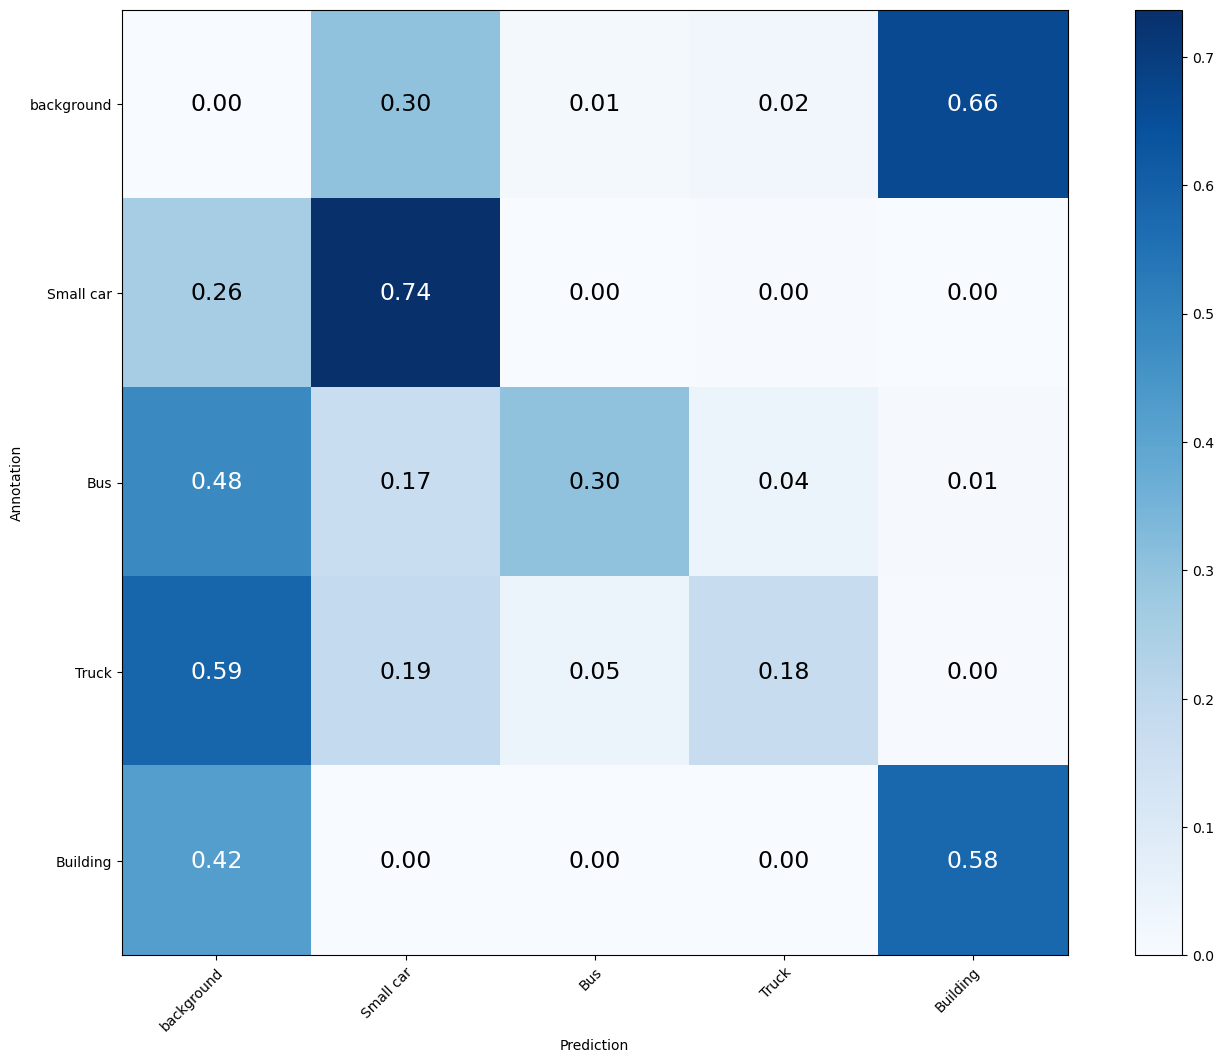

In [10]:
import numpy as np
import torch
from tqdm.auto import tqdm

num_fg_classes = len(catid_to_idx)      # 4
num_classes_cm = num_fg_classes + 1     # +1 for background index 0

cm = np.zeros((num_classes_cm, num_classes_cm), dtype=np.int64)  # [gt, pred]

iou_thresh = 0.5
score_thresh = 0.5   # solo consideramos predicciones con score >= score_thresh

model.eval()

with torch.no_grad():
    for images, targets in tqdm(valid_loader, desc="Evaluating"):
        # asumiendo batch_size=1 en valid_loader
        img = images[0].to(device)
        gt = targets[0]

        outputs = model([img])
        output = outputs[0]

        gt_boxes = gt["boxes"].cpu().numpy()
        gt_labels = gt["labels"].cpu().numpy()     # 1..4

        pred_boxes = output["boxes"].cpu().numpy()
        pred_scores = output["scores"].cpu().numpy()
        pred_labels = output["labels"].cpu().numpy()   # 0..4

        # filtrar por score
        keep = pred_scores >= score_thresh
        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]
        pred_labels = pred_labels[keep]

        n_gt = len(gt_boxes)
        n_pred = len(pred_boxes)

        # si no hay GT ni preds, no aporta nada
        if n_gt == 0 and n_pred == 0:
            continue

        # matriz IoU [num_pred x num_gt]
        if n_gt > 0 and n_pred > 0:
            inter = np.zeros((n_pred, n_gt))
            uni   = np.zeros((n_pred, n_gt))
            for p_idx, pb in enumerate(pred_boxes):
                inter[p_idx] = area_intersection(gt_boxes, pb)
                uni[p_idx]   = area_union(gt_boxes, pb)
            ious = inter / np.maximum(uni, np.finfo(np.float64).eps)
        else:
            ious = np.zeros((n_pred, n_gt))

        matched_gt = np.zeros(n_gt, dtype=bool)
        matched_pred = np.zeros(n_pred, dtype=bool)

        # Primero: asignación tipo "best match" por GT
        for g_idx in range(n_gt):
            gl = int(gt_labels[g_idx])          # 1..4
            gt_box = gt_boxes[g_idx]

            if n_pred == 0:
                continue

            iou_vals = ious[:, g_idx]
            best_idx = np.argmax(iou_vals)
            best_iou = iou_vals[best_idx]

            if best_iou >= iou_thresh:
                pl = int(pred_labels[best_idx])  # 0..4

                # clamp pred label to [0..num_fg_classes]
                if pl < 0 or pl > num_fg_classes:
                    pl = 0

                cm[gl, pl] += 1

                matched_gt[g_idx] = True
                matched_pred[best_idx] = True
            else:
                # no pred con IOU suficiente -> FN (gt vs background)
                cm[gl, 0] += 1
                matched_gt[g_idx] = True  # already accounted as FN

        # FNs para GTs que nunca tuvieron ningún pred candidate (n_pred == 0 caso)
        for g_idx in range(n_gt):
            if not matched_gt[g_idx]:
                gl = int(gt_labels[g_idx])
                if gl < 0 or gl > num_fg_classes:
                    gl = 0
                cm[gl, 0] += 1

        # FPs: predicciones sin GT asociado -> background vs pred class
        for p_idx in range(n_pred):
            if not matched_pred[p_idx]:
                pl = int(pred_labels[p_idx])
                if pl < 0 or pl > num_fg_classes:
                    pl = 0
                cm[0, pl] += 1

# index 0 = background
# 1..4 = Small car, Bus, Truck, Building
category_names = ["background"] + [categories[i] for i in range(num_fg_classes)]

draw_confusion_matrix(cm, category_names)


PR eval:   0%|          | 0/761 [00:00<?, ?it/s]

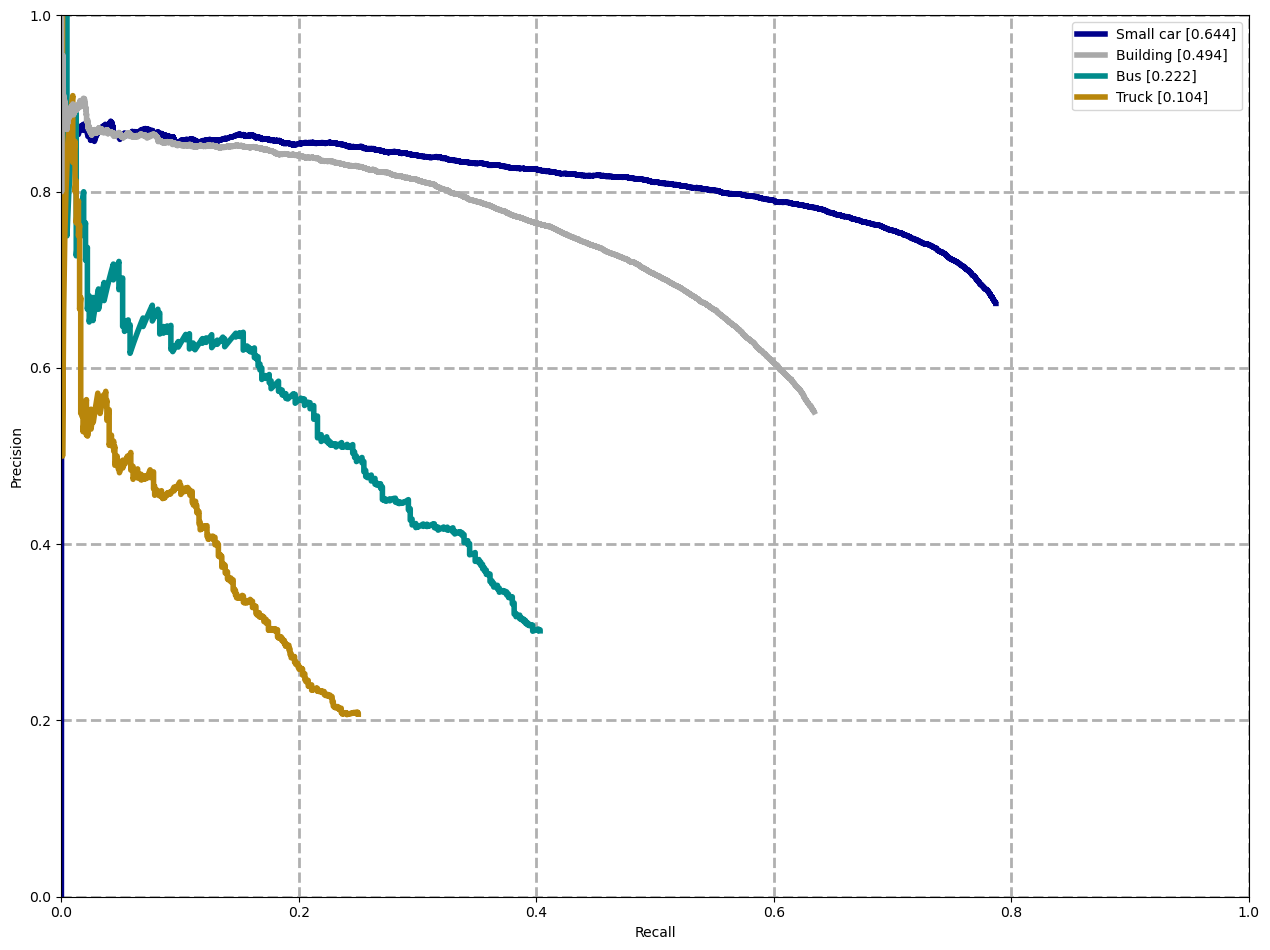

In [11]:
def compute_pr_curves(model, dataset, device, iou_thresh=0.5, score_thresh=0.0):
    model.eval()
    num_classes = len(catid_to_idx)

    # por clase: listas de (score, is_tp)
    class_scores = [[] for _ in range(num_classes)]
    class_tp = [[] for _ in range(num_classes)]
    class_total_gt = [0 for _ in range(num_classes)]

    with torch.no_grad():
        for i in tqdm(range(len(dataset)), desc="PR eval"):
            img, target = dataset[i]
            img_gpu = img.to(device)
            pred = model([img_gpu])[0]

            gt_boxes = target["boxes"].numpy()
            gt_labels = target["labels"].numpy() - 1      # 0..C-1
            pred_boxes = pred["boxes"].cpu().numpy()
            pred_scores = pred["scores"].cpu().numpy()
            pred_labels = pred["labels"].cpu().numpy() - 1

            # contar GTs por clase
            for gl in gt_labels:
                class_total_gt[int(gl)] += 1

            # filtrar por score
            keep = pred_scores >= score_thresh
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]
            pred_labels = pred_labels[keep]

            # marcar GTs como no usados aún
            used_gt = np.zeros(len(gt_boxes), dtype=bool)

            # ordenar predicciones por score desc
            order = np.argsort(-pred_scores)
            pred_boxes = pred_boxes[order]
            pred_scores = pred_scores[order]
            pred_labels = pred_labels[order]

            # para cada pred, ver si es TP o FP
            for pb, ps, pl in zip(pred_boxes, pred_scores, pred_labels):
                if len(gt_boxes) == 0:
                    class_scores[pl].append(ps)
                    class_tp[pl].append(0)
                    continue

                ious = area_intersection(gt_boxes, pb) / area_union(gt_boxes, pb)
                best_gt = np.argmax(ious)
                best_iou = ious[best_gt]

                if best_iou >= iou_thresh and (not used_gt[best_gt]) and (pl == gt_labels[best_gt]):
                    used_gt[best_gt] = True
                    class_scores[pl].append(ps)
                    class_tp[pl].append(1)   # TP
                else:
                    class_scores[pl].append(ps)
                    class_tp[pl].append(0)   # FP

    # ahora calculamos precision/recall por clase
    precisions = []
    recalls = []

    for c in range(num_classes):
        if len(class_scores[c]) == 0 or class_total_gt[c] == 0:
            precisions.append(np.array([0.0]))
            recalls.append(np.array([0.0]))
            continue

        # ordenar por score otra vez por si acaso
        order = np.argsort(-np.array(class_scores[c]))
        tp = np.array(class_tp[c])[order]
        fp = 1 - tp

        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)

        rec = tp_cum / class_total_gt[c]
        prec = tp_cum / np.maximum(tp_cum + fp_cum, np.finfo(np.float64).eps)

        precisions.append(prec)
        recalls.append(rec)

    return precisions, recalls

precisions, recalls = compute_pr_curves(model, valid_dataset, device)

# nombres de clases (mismo orden que catid_to_idx)
inv_map = {v: k for k, v in catid_to_idx.items()}
category_names = [str(inv_map[i]) for i in range(len(catid_to_idx))]

draw_precision_recall(precisions, recalls, category_names)


In [12]:
model.eval()


import os
import numpy as np

anns = []
for dirpath, _, filenames in os.walk('../PROJECT/xview_detection/xview_test'):
    for f in filenames:
        img = GenericImage(os.path.join(dirpath, f))  # ← ruta correcta
        img.tile = np.array([0, 0, 640, 640])
        anns.append(img)

print(f'Number of testing images: {len(anns)}')



Number of testing images: 852


In [13]:
predictions_data = {
    "images": {},
    "annotations": {},
    "categories": categories
}

def get_img_path(img):
    for attr in ["path", "filename", "file_name", "image_name", "impath"]:
        if hasattr(img, attr):
            return getattr(img, attr)
    raise AttributeError("GenericImage has no path-like attribute")

In [14]:
import torch
from PIL import Image
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

transform = T.Compose([
    T.ToTensor()
])

predictions = {}

for img in anns:
    img_path = get_img_path(img)

    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)[0]

    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    labels = output["labels"].cpu().numpy()

    predictions[img_path] = {}

    for box, score, label in zip(boxes, scores, labels):
        cat = int(label)

        if cat not in predictions[img_path]:
            predictions[img_path][cat] = {
                "bbox": [],
                "confidence": []
            }

        x1, y1, x2, y2 = box
        predictions[img_path][cat]["bbox"].append([x1, y1, x2, y2])
        predictions[img_path][cat]["confidence"].append(float(score))

In [15]:

# Save prediction
predictions_data = {"images": {}, "annotations": {}, "categories": {}}
predictions_data["categories"] = categories
imgs_idx, annos_idx = 0, 0

for pred, cats_dict in predictions.items():
    # 1) Contar objetos correctamente: suma de bboxes por categoría
    num_objects = sum(len(cats_dict[cat]["bbox"]) for cat in cats_dict)

    # 2) Guardar metadatos de la imagen
    image_data = {
        "image_id": pred.split("/")[-1],
        "filename": "/".join(pred.split("/")[-2:]),
        "num_objects": int(num_objects),
        "width": 640,
        "height": 640
    }
    predictions_data["images"][imgs_idx] = image_data
    imgs_idx += 1

    # 3) Guardar anotaciones (una por bbox)
    for cat_num, det in cats_dict.items():
        # cat_name es tipo "Small car", "Bus", etc.
        # Convertimos nombre -> id usando el diccionario categories
    

        bboxes = det.get("bbox", [])
        confs = det.get("confidence", [])

        # (por seguridad) si hay desajuste de longitudes, recortamos al mínimo
        n = min(len(bboxes), len(confs))

        for i in range(n):
            bbox = bboxes[i]
            conf = confs[i]

            annotation_data = {
                "image_id": pred.split("/")[-1],
                "category_id": categories[int(cat_num)-1],
                "bbox": (
                    int(round(bbox[0])),
                    int(round(bbox[1])),
                    int(round(bbox[2])),
                    int(round(bbox[3]))
                ),
                "confidence": f"{conf:.8f}"

            }
            predictions_data["annotations"][annos_idx] = annotation_data
            annos_idx += 1
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)